[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rajgiriUW/imskpm/blob/main/imskpm/notebooks/IM-SKPM%20CoLab.ipynb)

## Intensity-Modulated Scanning Kelvin Probe Microscopy (IM-SKPM)

A simple package for simulating IM-SKPM in photovoltaics based on conventional charge density recombination ODE. 

This approach simulates equations of the form:

$\frac {dn} {dt} = G-k_1n -k_2n^2-k_3n^3$

where:
* $n$ = carrier density (#$/cm^3$)
* $\frac {dn} {dt} $ = change in carrier density (#$/{cm^3s}$)
* $G$ = generation rate (#$/cm^3$)
* $k_1$ = monomoecular recombination rate ($/s$), trapping/nonradiative recombination
* $k_2$ = bimolecular recombination rate ($cm^3/s$), band-band/radiative recombination
* $k_3$ = third order recombination rate ($cm^6/s$), Auger recombination

See, for example:
deQuilettes,et al. "Charge-Carrier Recombination in Halide Perovskites." Chemical Reviews **119**, 11007-11019 (2019).[DOI:10.1021/acs.chemrev.9b00169.](https://doi.org/10.1021/acs.chemrev.9b00169)

###### Package location:
* [IMSKPM](https://github.com/rajgiriUW/imskpm/)

###### Installation instructions:

* Clone or download the code from the link above (it is not on PyPi or other package sites...yet)
* In a command window, navigate to the folder where this is installed, then type:
```python setup.py```
or 
```python setup.py develop```

Then use 

```import imskpm``` 

or follow the commands in the cells below.

###### For more information:
```
Rajiv Giridharagopal, Ph.D.
University of Washington
rgiri@uw.edu
```

In [4]:
 !sudo apt-get install python3.8
 !git clone https://github.com/rajgiriUW/imskpm
 %cd /content/imskpm
 !python setup.py develop
 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.8 is already the newest version (3.8.13-1+bionic2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
fatal: destination path 'imskpm' already exists and is not an empty directory.
/content/imskpm
running develop
running egg_info
writing IMSKPM.egg-info/PKG-INFO
writing dependency_links to IMSKPM.egg-info/dependency_links.txt
writing requirements to IMSKPM.egg-info/requires.txt
writing top-level names to IMSKPM.egg-info/top_level.txt
writing manifest file 'IMSKPM.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/IMSKPM.egg-link (link to .)
IMSKPM 0.0.1 is already the active version in easy-install.pth

Installed /content/imskpm
Processing dependencies for IMSKPM==0.0.1
Searching for scipy==1.4.1

In [5]:
import imskpm as imskpm
from imskpm.imskpmpoint import IMSKPMPoint
from imskpm.imskpmsweep import IMSKPMSweep

### Simulating a single IM-SKPM curve

There are two main Classes in the code as currently constructed, an ```IMSKPMPoint``` class and a ```IMSKPMSweep``` class that inherits IMSKPMPoint. Meaning, ```IMSKPMSweep``` calls the ```IMSKPMPoint``` Constructor and contains a superset of the same child functions. Both are very short (<400 lines), so I highly recommend you look through the functions to see what is going on.

Here is the set of (current) initial parameters when calling ```IMSKPMPoint(..)``` (i.e. you can call ```IMSKPM(intensity=..., k1=...)```:
```
intensity = 0.1,
k1 = 1e6,
k2 = 1e-10,
k3 = 0,
thickness = 500e-7
```

The IMSKPMPoint calls a few other functions:
```
kinetics(k1, k2, k3, absorbance = 1)
exc_source(intensity, wl=455e-9, NA=0.6)
make_pulse()
```

These set up the various parameters.
* ```kinetics(..)``` just assigns those values to the internal ```self.k1, self.k2, self.k3``` variables if you want to change them. 
* ```exc_source(..)``` defines the incident excitation source light area + wavelength. 
* ```make_pulse(..)``` creates a single light pulse. Here, the rise time and fall time for the pulse could be specified. Otherwise, the carrier density is calculated assuming the light is a step function (but the resultant carrier junction won't be, of course). You specify the timings 

The actual simulation is called by ```simulate```, which itself calls one of the functions in ```odes```. The default is ```dn_dt_g``` which is the simple rate equation in the first cell. But, you can supply anything.

The outcome of the simulations are then stored in:

* ``` voltage : ndArray``` The calculated voltage
* ``` omega0 : ndArray``` Resonance frequency shift of the cantilever (Hz)
* ``` n_dens : ndArray``` Charge density in the film due to ODE (Generation - Recombination) (#/cm^3).
* ``` sol :  `OdeSolution``` (From Scipy) Found solution as `OdeSolution` instance
* ``` gen : ndArray``` Carrier concentration GENERATED (#/cm^3).

In [6]:
device = IMSKPMPoint(k1=1e6, k2=1e-10, k3=0)
frequency = 10000 # 10 kHz
device.make_pulse(0,0,pulse_time = 1/frequency, start_time = 1/(4*frequency), pulse_width = 1/(2*frequency))
device.simulate()


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb16794aad0>)

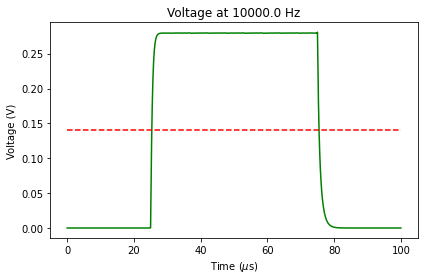

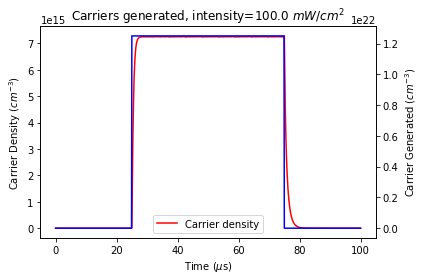

In [7]:
# Plot the result
device.plot(semilog=False, charge_only=False)

### This simulates a single pulse

The top graph shows the voltage in *green*. The average voltage is in *red*. The voltage is calculated using some rough assumptions via Gauss's law, but in general it's based on the carrier density.

Again: **the red curve=left axis is the answer**. The blue curve is more for when we care about laser source rise times. That should be clear since 1e22 /cm^3 is unrealistically high for a perovskite, but 1e15 /cm^3 is pretty typical.

The bottom graph is what is *actually* being simulated. The blue curve represents the carriers generated (right axis). The red curve represents the actual carrier density (left axis). What is the difference? The red curve includes recombination. The blue curve is more relevant when you do complicated pulse trains, or add an actual rise time to your light pulse, and so on.

Let's make this more interesting and change up the lifetimes.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1653b2b50>)

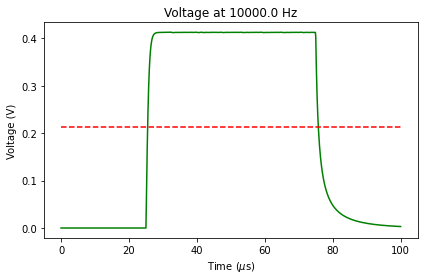

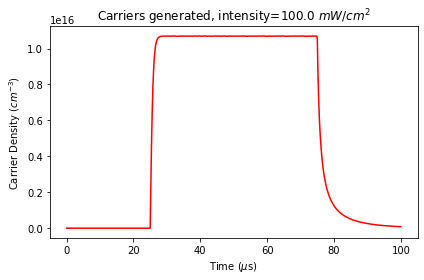

In [8]:
device.kinetics(k1=1e5, k2=1e-10,k3=0) 
device.simulate()
device.plot()

### What changed?

We changed ```k1``` to be 10^5 /s, which is ridiculous (10 microseconds!). But as a result, the carrier density is a magnitude higher, and we see slower relaxation because there are so many more carriers

Similarly, let's take the case of a much worse perovskite.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1652677d0>)

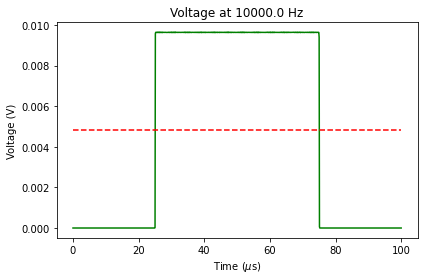

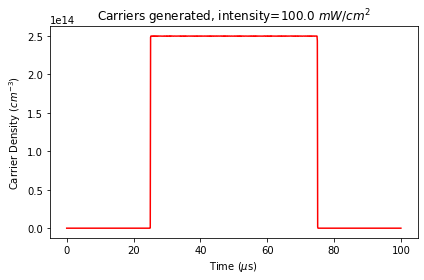

In [9]:
device.kinetics(k1=5e7, k2=1e-10,k3=0) #
device.simulate()
device.plot()

### What changed?

We changed ```k1``` to be 5e7 /s, which is quite bad (20 nanoseconds!). Now, the carriers saturate much more quickly because of the recombination rate being so high. These effects play a significant role in how IM-SKPM curves are generated.

There are other factors we could change, but they mostly just change the magnitude. For example, the intensity (```device.intensity```) doesn't really affect anything, except that it scales how many carriers are generated. ```intensity=0.1``` means 100 mW/cm^2 (1 Sun). Likewise, the ```wl (wavelength``` and ```NA (numerical aperture)``` are mostly there for calculating the area of excitation, but they aren't used directly in simulations.

/content/imskpm/imskpm/odes.py:41: RuntimeWarning: overflow encountered in power
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3
/content/imskpm/imskpm/odes.py:41: RuntimeWarning: invalid value encountered in multiply
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1643a8690>)

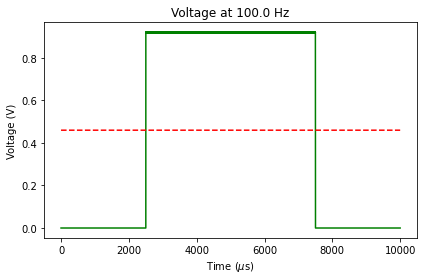

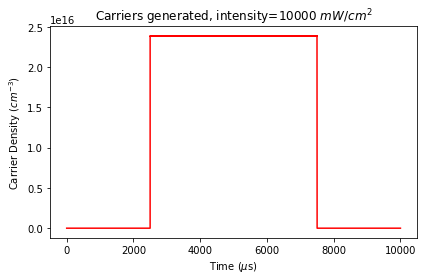

In [10]:
device.exc_source(intensity=10, wl=455e-9, NA=0.6)
device.make_pulse() # if we change the excitation, we shoud update the pulse
device.simulate()
device.plot()

### What changed?

We have 100X more intensity, so as a result the carrier density changed by quite a lot.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb165101050>)

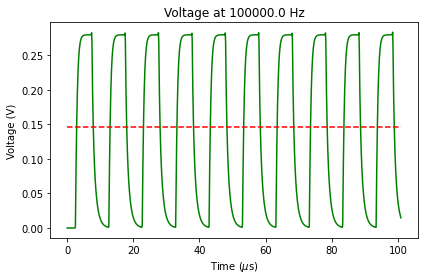

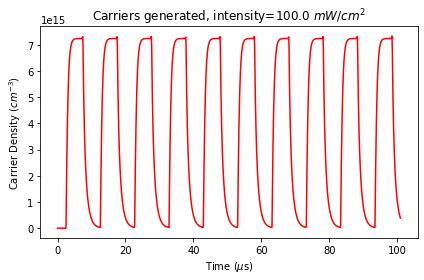

In [11]:
frequency = 100000 # 10 kHz

device = IMSKPMPoint()
device.kinetics(k1 = 1e6, k2=1e-10,k3=0)
device.make_pulse(0,0,pulse_time = 1/frequency, start_time = 1/(4*frequency), pulse_width = 1/(2*frequency))
device.pulse_train(max_cycles=10)
device.simulate()
device.plot()

### What changed?

Now we added a pulse train to the mix by repeating the individual pulse 10 times (defined by ```max_cycles```).

Therefore, the resulting simulation includes several up and down cycles.

What happens when the modulation rate goes up? At some point the system will not be fast enough to respond!


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1652cb490>)

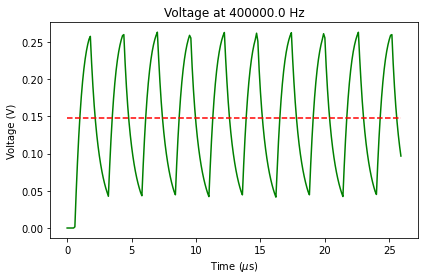

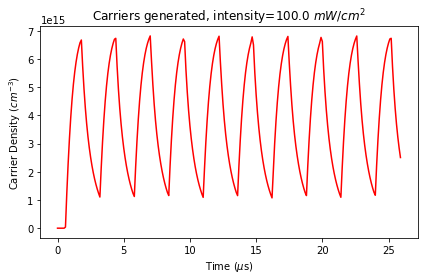

In [12]:
frequency = 4e5
device.make_pulse(0,0,pulse_time = 1/frequency, start_time = 1/(4*frequency), pulse_width = 1/(2*frequency))
device.pulse_train(max_cycles=10)
device.simulate()
device.plot()

## Changing the simulation

By default the simulation uses the equation up above and is reasonably integrated into the code. But you can define any new equation you want and use that.

The function lives ```imskpm.odes.py``` in the repository.

To do so, we will also need to pass the arguments to the function (the constants). The value of ```pulse``` and ```dt``` are there to allow us to pass the generated carriers from the light pulse into the function, since that is not constant.

```
def new_dn_dt(t, n, i, k1, k2, k3=0, pulse, dt):
    
    tidx = min(int(np.floor(t / dt)), len(pulse)-1) 
    g = pulse[tidx]
    
    return g - k1*(n-i) + k2 * n**2 + k3 * n**3
    
```

Now we added some change to the carrier density to first order. To update the code.

```
i = 1e3 # 10^15/cm^3 into /um^3
gen = device.gen_t(device.absorbance, device.pulse, device.thickness)
gen = gen * 1e-12 # to convert to /um^3 for computational accuracy
device.args = (i, device.k1, device.k2, device.k3, gen, device.tx[1]-device.tx[0])
device.func = new_dn_dt
device.calc_n_dot()
```

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb167add6d0>)

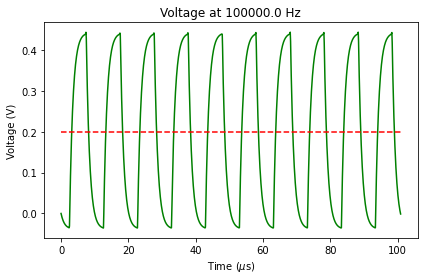

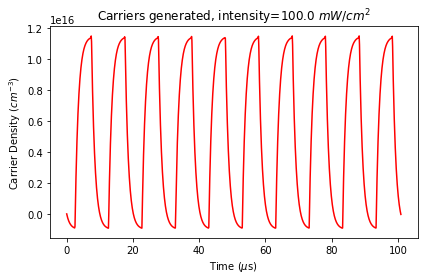

In [13]:
import numpy as np

# define a new function
# you generally always want the first two lines (to find the input light pulse value)
def new_dn_dt(t, n, i, k1, k2, k3, pulse, dt):

    tidx = min(int(np.floor(t / dt)), len(pulse)-1) 
    g = pulse[tidx]

    return g - k1*(n+i) + k2 * n**2 + k3 * n**3


frequency = 1e5

device = IMSKPMPoint()
device.kinetics(k1 = 1e6, k2=1e-10,k3=0)
device.make_pulse(0,0,pulse_time = 1/frequency, start_time = 1/(4*frequency), pulse_width = 1/(2*frequency))
device.pulse_train(max_cycles=10)

i = 1e3 # 10^15/cm^3 into /um^3
gen = imskpm.calc_utils.gen_t(device.absorbance, device.pulse, device.thickness)
gen = gen * 1e-12 # to convert to /um^3 for computational accuracy
device.args = (i, device.k1, device.k2, device.k3, gen, device.dt)
device.func = new_dn_dt
device.simulate()
device.plot()

### What changed?

We defined a new fitting function, so the resulting outcome is quite different. Here, there's a change in the first order kinetics

## Simulating a sweep

Here, we use the class ```IMSKPMSweep``` to probe a series of frequencies.
Some notes about this:

* very low frequencies require many points and are thus very slow to simulate. Fortunately, we also care the least about these
* you can set the frequencies explicitly that you wish to simulate

Let's go through a basic IM-SKPM curve and see the result.

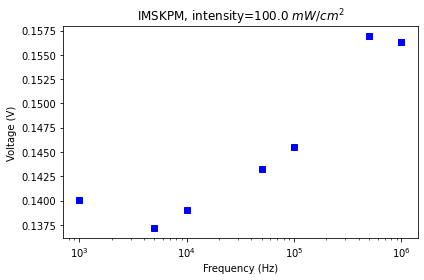

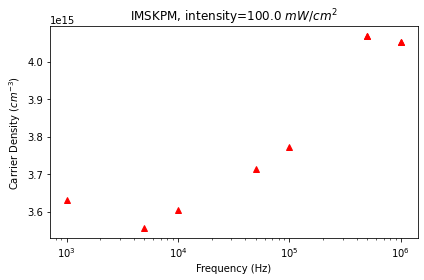

In [14]:
from imskpm.imskpmsweep import IMSKPMSweep
devicesweep = IMSKPMSweep(k1=1e6, k2=1e-10, k3=0)

# Let's update the default list (which is from 100 Hz to 80 MHz) to save time
import numpy as np
devicesweep.frequency_list = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e5,1e6])
devicesweep.simulate_sweep(verbose=False) #verbose displays outputs to the command window for feedback
devicesweep.plot()

### What happened?

This completed a standard IMSKPM Sweep. If we want to change the simulation ODE function, we need to change ```devicesweep.func``` to another *valid* ODE. See ```odes.py``` file for more details. The default is the same used in standard simulations of PL lifetimes, for example.

The top plot is the voltage. Again, the voltage is calculated in a fairly crude manner using Gauss's law with a parallel plate capacitor. The bottom plot is the average carrier density from the simulations. Those two factors should be related.

Let's change some other parameters. The first one you might not think about is the lift height! To get around that, we can use a much lower lift height and get higher voltage values.

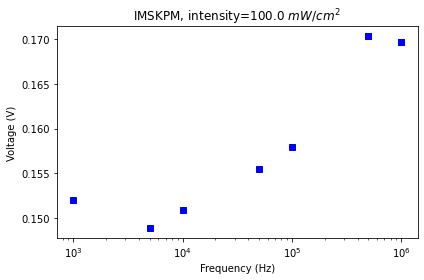

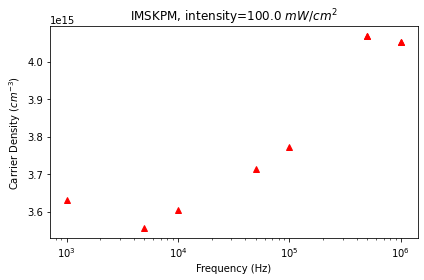

In [15]:
devicesweep.lift_height = 1e-9
devicesweep.simulate_sweep()
devicesweep.fit()
devicesweep.plot()

### What happened?

The change in lift height increased the voltage calculated in the top plot to increase by quite a lot, as would be expected.

Now, let's change the light intensity and see what happens.

/content/imskpm/imskpm/odes.py:41: RuntimeWarning: overflow encountered in power
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3
/content/imskpm/imskpm/odes.py:41: RuntimeWarning: invalid value encountered in multiply
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3


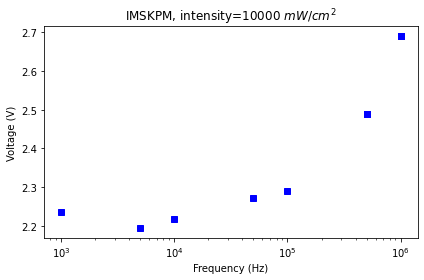

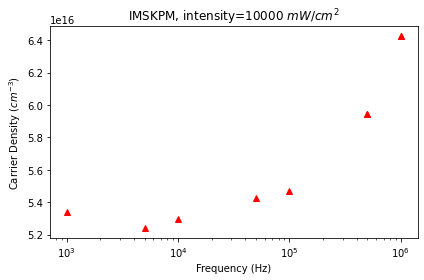

In [16]:
devicesweep.intensity=10
devicesweep.simulate_sweep()
devicesweep.plot()

### What happened?

The change in intensity shifted the IM-SKPM curve to the right, as makes sense given that we're shortening the lifetimes by having higher intensity. 

What about changing the recombination rate (we'll go back to lower intensity)

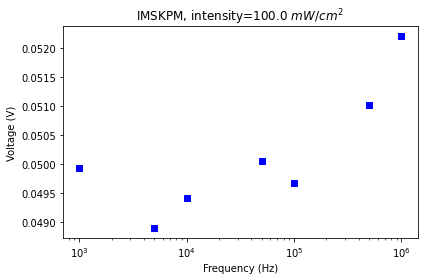

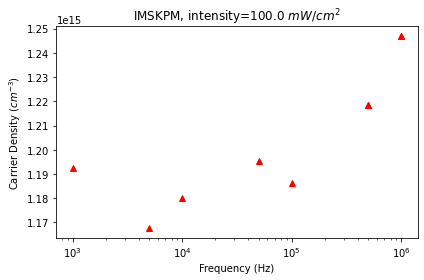

In [17]:
devicesweep.intensity=0.1
devicesweep.kinetics(k1=5e6, k2=1e-10, k3=0)
devicesweep.simulate_sweep(verbose=False)
devicesweep.plot()

### What happened?

The much higher ```k1``` results in significantly more recombination. This has the effect of lowering the carrier density, reducing the voltage (less charge on the bottom plate of the capacitor).

For much higher recombination rates, the simulation sweeps can get very noisy. So, there's a realistic range where we care about "good" perovskites that these seem to work well. 

We'll quickly try one that is much better (10 us lifetime) and we'll see that we start to get that build-up regime concern at higher frequencies.

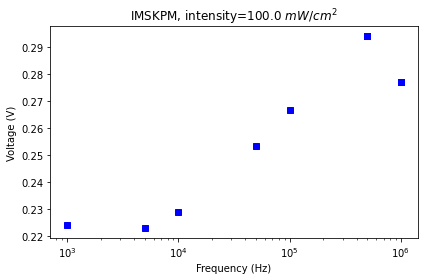

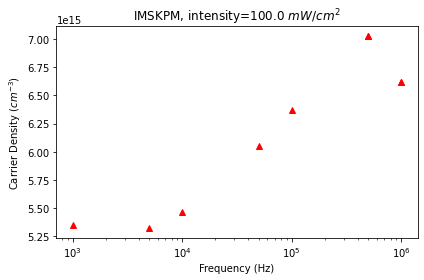

In [18]:
devicesweep.intensity=0.1
devicesweep.kinetics(k1=1e5, k2=1e-10, k3=0)
devicesweep.simulate_sweep(verbose=False)
devicesweep.plot()

### Where to go from here?

The most obvious is changing the simple rate equation to more complex ones, or explicitly including effects of generation in there. The other potential move is changing the simulation 